Trying to replicate results from https://www.researchgate.net/profile/Salma-Alhagry/publication/320802497_Emotion_Recognition_based_on_EEG_using_LSTM_Recurrent_Neural_Network/links/5b39ff5a0f7e9b0df5e4cf26/Emotion-Recognition-based-on-EEG-using-LSTM-Recurrent-Neural-Network.pdf



In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import scipy.io
import scipy.signal
from einops import reduce, rearrange
import numpy as np

In [2]:
# Constants used to define data paths
ROOT_DIR = './'
RAW_DIR = 'data/matlabPREPROCESSED'
PROCESSED_DIR = 'data/graphProcessedData'

In [3]:
raw_file_names = os.listdir(RAW_DIR)
raw_file_names.sort()
all_subjects = [scipy.io.loadmat(f'{RAW_DIR}/{name}') for name in raw_file_names]

In [4]:
all_data = [subject['data'] for subject in all_subjects]
all_labels = [subject['labels'] for subject in all_subjects]
labels = np.stack(all_labels)
data = np.stack(all_data)

In [5]:
data = data[:,:,:32,:]

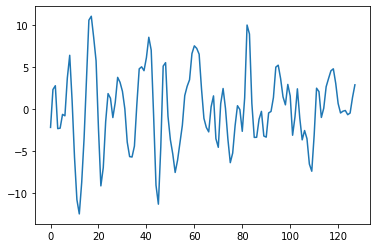

In [6]:
import matplotlib.pyplot as plt
plt.plot(data[0,0,2,:128].T)
plt.show()

In [7]:
data.shape

(32, 40, 32, 8064)

In [8]:
all_labels = rearrange(labels,'s v c -> (s v) c')
all_data = rearrange(data,'s v c (d a) -> (s v) d (c a)', a=672)

In [9]:
data.shape, all_data.shape, labels.shape, all_labels.shape

((32, 40, 32, 8064), (1280, 12, 21504), (32, 40, 4), (1280, 4))

In [11]:
split_idx = 960

In [13]:
all_data = torch.FloatTensor(all_data)
train_x, train_y = all_data[:split_idx], torch.FloatTensor(all_labels[:split_idx,target])
test_x, test_y = all_data[split_idx:], torch.FloatTensor(all_labels[split_idx:,target])
train_y = (train_y > 5).float()
test_y = (test_y > 5).float()

In [14]:
train_x.shape, train_y.shape, test_x.shape, test_y.shape

(torch.Size([960, 12, 21504]),
 torch.Size([960]),
 torch.Size([320, 12, 21504]),
 torch.Size([320]))

In [16]:
train_data = [(x,y) for x,y in zip(train_x,train_y)]
# val_data = [(x,y) for x,y in zip(val_x,val_y)]
test_data = [(x,y) for x,y in zip(test_x,test_y)]

In [17]:
BS = 4
# train_loader = torch.utils.data.DataLoader(train_data, batch_size=BS, shuffle=True)
# val_loader = torch.utils.data.DataLoader(val_data, batch_size=BS)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=BS)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = torch.device('cpu')

In [19]:
class Model(torch.nn.Module):
    def __init__(self, in_channels,hidden_channels):
        super(Model, self).__init__()
        self.lstm1 = nn.LSTM(21504, 64, 1, batch_first=True).to(device)
        self.lstm2 = nn.LSTM(64, 32, 1, batch_first=True).to(device)
        self.lin = nn.Linear(32,1).to(device)
    def forward(self, x):
        x, (h,c) = self.lstm1(x)
        x = x.relu()
        x = F.dropout(x, p=0.2, training=self.training)
        o, (h,c) = self.lstm2(x)
        x = h.squeeze()
        x = x.sigmoid()
        x = self.lin(x)
        x = x.sigmoid()
        return x.view(-1)

In [36]:
model = Model(all_data.shape[-1],hidden_channels=8)     
pytorch_total_params = sum(p.numel() for p in model.parameters())
print(f'Model parameter count: {pytorch_total_params}')

# optimizer = torch.optim.Adadelta(model.parameters(), lr=.1, rho=0.9, eps=1e-06, weight_decay=1e-5)
# optimizer = torch.optim.SGD(model.parameters(),lr=1e-1, weight_decay=1e-3)
# optimizer = torch.optim.Adam(model.parameters(), lr=.05, betas=(0.9, 0.999), eps=1e-08, weight_decay=0, amsgrad=True)
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=1e-3)

criterion = nn.BCELoss()

model = model.to(device)
# criterion = nn.MSELoss()


def train(loader):
    model.train()
    losses = []
    right = 0
    tot = 0
    for x,y in loader:
        optimizer.zero_grad()
        x, y = x.to(device), y.to(device)
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        losses.append(loss.item())
        optimizer.step()
        right += torch.eq(out > 0.5, y > 0.5).sum().item()
        tot += y.shape[0]
    return np.array(losses).mean(), right/tot

def test(loader,verbose=False):
    model.eval()
    losses = []
    right = 0
    tot = 0
    for x,y in loader:
        x, y = x.to(device), y.to(device)
        out = model(x)
        if verbose:
            print(out,y)
        right += torch.eq(out > 0.5, y > 0.5).sum().item()
        tot += y.shape[0]
        loss = criterion(out,y)
        losses.append(loss.item())
    return np.array(losses).mean(), right/tot

best_val_loss = np.inf
esp = 0
MAX_ESP = 100

BS = 1

k_folds = 4
k_fold_size = len(train_data)/k_folds
current_fold = 0 # Ranges from 0 to k_folds-1

for epoch in range(1, 10000):    
    # KFOLD train/val split     
    if epoch %10 == 0:
        current_fold = current_fold+1 if current_fold < k_folds-1 else 0
    from_idx, to_idx = int(k_fold_size*current_fold), int(k_fold_size*(current_fold+1))
    kf_val_data = train_data[from_idx:to_idx]
    a = train_data[:from_idx]
    b = train_data[to_idx:]
    kf_train_data = a + b
    train_loader = torch.utils.data.DataLoader(kf_train_data, batch_size=BS, shuffle=False)
    val_loader = torch.utils.data.DataLoader(kf_val_data, batch_size=BS)
        
    # Training and validation
    train_loss, train_acc = train(train_loader)
    val_loss, val_acc = test(val_loader )
    print(f'Epoch {epoch} - Kfold:{current_fold} ;t loss: {train_loss:.5f} ;t acc: {train_acc:.2f} ;v loss: {val_loss:.5f} ;v acc: {val_acc:.2f}')

    # Early stopping and checkpoint
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        esp = 0
        torch.save(model.state_dict(),'./best_params') 
    else:
        esp += 1
        if esp >= MAX_ESP:
            break
            
    if epoch % 10 == 0:
        test_loader = torch.utils.data.DataLoader(test_data, batch_size=8)
        loss, acc = test(test_loader, True)
        print(f'Test loss: {loss} ; Test acc: {acc}')
        
#     scheduler.step()


print('Finished training')

Model parameter count: 5534497
Epoch 1 - Kfold:0 ;t loss: 0.69330 ;t acc: 0.53 ;v loss: 0.69702 ;v acc: 0.45
Epoch 2 - Kfold:0 ;t loss: 0.69341 ;t acc: 0.53 ;v loss: 0.69621 ;v acc: 0.45
Epoch 3 - Kfold:0 ;t loss: 0.69276 ;t acc: 0.53 ;v loss: 0.69690 ;v acc: 0.45
Epoch 4 - Kfold:0 ;t loss: 0.69321 ;t acc: 0.53 ;v loss: 0.69735 ;v acc: 0.45
Epoch 5 - Kfold:0 ;t loss: 0.69205 ;t acc: 0.53 ;v loss: 0.69651 ;v acc: 0.45
Epoch 6 - Kfold:0 ;t loss: 0.68823 ;t acc: 0.55 ;v loss: 0.70484 ;v acc: 0.44
Epoch 7 - Kfold:0 ;t loss: 0.68369 ;t acc: 0.56 ;v loss: 0.71149 ;v acc: 0.43
Epoch 8 - Kfold:0 ;t loss: 0.66719 ;t acc: 0.60 ;v loss: 0.76029 ;v acc: 0.45
Epoch 9 - Kfold:0 ;t loss: 0.66099 ;t acc: 0.60 ;v loss: 0.74266 ;v acc: 0.44
Epoch 10 - Kfold:1 ;t loss: 0.66753 ;t acc: 0.59 ;v loss: 0.66780 ;v acc: 0.61
tensor([0.4015, 0.3811, 0.3920, 0.5051, 0.4099, 0.4065, 0.3898, 0.4728],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0

Epoch 14 - Kfold:1 ;t loss: 0.59773 ;t acc: 0.70 ;v loss: 0.72866 ;v acc: 0.57
Epoch 15 - Kfold:1 ;t loss: 0.57762 ;t acc: 0.72 ;v loss: 0.79835 ;v acc: 0.54
Epoch 16 - Kfold:1 ;t loss: 0.57329 ;t acc: 0.72 ;v loss: 0.80681 ;v acc: 0.48
Epoch 17 - Kfold:1 ;t loss: 0.52642 ;t acc: 0.76 ;v loss: 0.79559 ;v acc: 0.47
Epoch 18 - Kfold:1 ;t loss: 0.52858 ;t acc: 0.75 ;v loss: 0.83988 ;v acc: 0.50
Epoch 19 - Kfold:1 ;t loss: 0.53660 ;t acc: 0.75 ;v loss: 0.85664 ;v acc: 0.46
Epoch 20 - Kfold:2 ;t loss: 0.59213 ;t acc: 0.67 ;v loss: 0.55276 ;v acc: 0.72
tensor([0.2135, 0.3264, 0.2830, 0.2349, 0.2415, 0.1556, 0.3118, 0.3780],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.4499, 0.3134, 0.3036, 0.1799, 0.3160, 0.2619, 0.6227, 0.4706],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.1781, 0.2873, 0.4210, 0.4961, 0.5562, 0.2147, 0.2585, 0.5521],
       device='c

Epoch 27 - Kfold:2 ;t loss: 0.48569 ;t acc: 0.79 ;v loss: 0.68389 ;v acc: 0.62
Epoch 28 - Kfold:2 ;t loss: 0.45676 ;t acc: 0.79 ;v loss: 0.76188 ;v acc: 0.60
Epoch 29 - Kfold:2 ;t loss: 0.44996 ;t acc: 0.80 ;v loss: 0.78959 ;v acc: 0.55
Epoch 30 - Kfold:3 ;t loss: 0.52646 ;t acc: 0.72 ;v loss: 0.54252 ;v acc: 0.76
tensor([0.5485, 0.3973, 0.4192, 0.6519, 0.5580, 0.3424, 0.5300, 0.4369],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.5795, 0.6293, 0.4770, 0.5426, 0.5205, 0.3517, 0.6095, 0.5893],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.5950, 0.7750, 0.4361, 0.3313, 0.3931, 0.6618, 0.5486, 0.6933],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.7103, 0.4842, 0.4939, 0.5563, 0.4260, 0.5006, 0.5799, 0.6821],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 1., 1., 0.

Epoch 40 - Kfold:0 ;t loss: 0.51999 ;t acc: 0.74 ;v loss: 0.58346 ;v acc: 0.72
tensor([0.5907, 0.3290, 0.4118, 0.6037, 0.3562, 0.3122, 0.4909, 0.4944],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.5241, 0.2828, 0.2839, 0.3914, 0.5111, 0.4567, 0.5278, 0.4598],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.6142, 0.4578, 0.5205, 0.4958, 0.4129, 0.5461, 0.5054, 0.6058],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.4494, 0.3073, 0.1675, 0.3470, 0.3825, 0.3346, 0.3436, 0.5284],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0.4611, 0.5193, 0.4431, 0.5017, 0.3448, 0.3750, 0.3333, 0.4346],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0.4868, 0.4402, 0.

tensor([0.2020, 0.4630, 0.6498, 0.1421, 0.2787, 0.2201, 0.4397, 0.5043],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 1., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0.2817, 0.2048, 0.3352, 0.3463, 0.3021, 0.1749, 0.1493, 0.2092],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 1., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0.1195, 0.3203, 0.4511, 0.6112, 0.3047, 0.3490, 0.5450, 0.5969],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')
Test loss: 0.88648871332407 ; Test acc: 0.475
Epoch 51 - Kfold:1 ;t loss: 0.48459 ;t acc: 0.77 ;v loss: 0.53548 ;v acc: 0.75
Epoch 52 - Kfold:1 ;t loss: 0.45289 ;t acc: 0.79 ;v loss: 0.66456 ;v acc: 0.68
Epoch 53 - Kfold:1 ;t loss: 0.45295 ;t acc: 0.79 ;v loss: 0.59505 ;v acc: 0.65
Epoch 54 - Kfold:1 ;t loss: 0.44082 ;t acc: 0.80 ;v loss: 0.67366 ;v acc: 0.61
Epoch 55 - Kfold:1 ;t loss: 0.41301 ;t acc: 0.82 ;v loss: 0.68477 ;v acc: 0.58
Epoch 56 - Kfold:1 ;t 

Epoch 61 - Kfold:2 ;t loss: 0.48375 ;t acc: 0.77 ;v loss: 0.45441 ;v acc: 0.78
Epoch 62 - Kfold:2 ;t loss: 0.46058 ;t acc: 0.80 ;v loss: 0.44214 ;v acc: 0.82
Epoch 63 - Kfold:2 ;t loss: 0.45808 ;t acc: 0.79 ;v loss: 0.58571 ;v acc: 0.70
Epoch 64 - Kfold:2 ;t loss: 0.44423 ;t acc: 0.80 ;v loss: 0.59699 ;v acc: 0.70
Epoch 65 - Kfold:2 ;t loss: 0.44857 ;t acc: 0.80 ;v loss: 0.69280 ;v acc: 0.61
Epoch 66 - Kfold:2 ;t loss: 0.45168 ;t acc: 0.81 ;v loss: 0.68783 ;v acc: 0.63
Epoch 67 - Kfold:2 ;t loss: 0.41871 ;t acc: 0.82 ;v loss: 0.70871 ;v acc: 0.61
Epoch 68 - Kfold:2 ;t loss: 0.45783 ;t acc: 0.80 ;v loss: 0.66096 ;v acc: 0.61
Epoch 69 - Kfold:2 ;t loss: 0.46332 ;t acc: 0.80 ;v loss: 0.66079 ;v acc: 0.65
Epoch 70 - Kfold:3 ;t loss: 0.50696 ;t acc: 0.73 ;v loss: 0.50030 ;v acc: 0.79
tensor([0.4429, 0.2772, 0.4413, 0.5569, 0.6024, 0.2166, 0.3042, 0.4172],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.3265, 0.6254, 0.2162,

Epoch 74 - Kfold:3 ;t loss: 0.43041 ;t acc: 0.81 ;v loss: 0.59909 ;v acc: 0.71
Epoch 75 - Kfold:3 ;t loss: 0.41434 ;t acc: 0.81 ;v loss: 0.66495 ;v acc: 0.66
Epoch 76 - Kfold:3 ;t loss: 0.41649 ;t acc: 0.81 ;v loss: 0.70514 ;v acc: 0.63
Epoch 77 - Kfold:3 ;t loss: 0.41867 ;t acc: 0.82 ;v loss: 0.76545 ;v acc: 0.63
Epoch 78 - Kfold:3 ;t loss: 0.41314 ;t acc: 0.81 ;v loss: 0.75879 ;v acc: 0.58
Epoch 79 - Kfold:3 ;t loss: 0.41477 ;t acc: 0.81 ;v loss: 0.84246 ;v acc: 0.58
Epoch 80 - Kfold:0 ;t loss: 0.50157 ;t acc: 0.72 ;v loss: 0.56741 ;v acc: 0.77
tensor([0.5049, 0.5501, 0.4606, 0.6359, 0.5738, 0.2140, 0.4072, 0.3522],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.6328, 0.4153, 0.3624, 0.4981, 0.5524, 0.3126, 0.3639, 0.4807],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.5063, 0.3675, 0.5699, 0.5391, 0.4494, 0.5020, 0.5668, 0.6306],
       device='c

Epoch 87 - Kfold:0 ;t loss: 0.45080 ;t acc: 0.79 ;v loss: 0.79863 ;v acc: 0.53
Epoch 88 - Kfold:0 ;t loss: 0.45938 ;t acc: 0.79 ;v loss: 0.83859 ;v acc: 0.49
Epoch 89 - Kfold:0 ;t loss: 0.43112 ;t acc: 0.79 ;v loss: 0.76587 ;v acc: 0.55
Epoch 90 - Kfold:1 ;t loss: 0.52359 ;t acc: 0.72 ;v loss: 0.51747 ;v acc: 0.74
tensor([0.2438, 0.2862, 0.6180, 0.5719, 0.5611, 0.1295, 0.1249, 0.3707],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.1977, 0.8352, 0.2190, 0.2449, 0.5648, 0.1994, 0.2534, 0.4030],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.5185, 0.1887, 0.1952, 0.3572, 0.1330, 0.3152, 0.1977, 0.4335],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.2304, 0.7251, 0.1817, 0.1960, 0.0713, 0.3134, 0.2631, 0.1906],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 1., 1., 0.

Epoch 100 - Kfold:2 ;t loss: 0.52380 ;t acc: 0.73 ;v loss: 0.42967 ;v acc: 0.82
tensor([0.5852, 0.3705, 0.2173, 0.8090, 0.1695, 0.1602, 0.2266, 0.1968],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.4552, 0.5289, 0.2018, 0.4817, 0.2316, 0.1576, 0.4577, 0.6216],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.7156, 0.1531, 0.6542, 0.6652, 0.1897, 0.3885, 0.1322, 0.6220],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.7527, 0.2227, 0.1464, 0.5703, 0.2098, 0.3266, 0.2232, 0.7712],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0.2510, 0.3299, 0.0952, 0.5442, 0.3217, 0.1044, 0.2644, 0.2889],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0.8240, 0.3989, 0

tensor([0.5689, 0.3911, 0.4834, 0.4543, 0.7375, 0.1889, 0.5919, 0.4668],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 1., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.3058, 0.2756, 0.6407, 0.2016, 0.3028, 0.6800, 0.5674, 0.3058],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([0.5596, 0.7372, 0.4256, 0.3925, 0.7556, 0.3877, 0.7215, 0.5341],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0.4775, 0.3151, 0.6537, 0.3291, 0.6546, 0.2216, 0.2479, 0.5334],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 1.], device='cuda:0')
tensor([0.4485, 0.7088, 0.4722, 0.2681, 0.5167, 0.2702, 0.5825, 0.6624],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0.4297, 0.5089, 0.3526, 0.8162, 0.6173, 0.5745, 0.3359, 0.2689],
       device='cuda:0', grad_fn=

tensor([0.6293, 0.6508, 0.3526, 0.6909, 0.4770, 0.2010, 0.5757, 0.7150],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 1.], device='cuda:0')
tensor([0.7107, 0.2296, 0.5506, 0.5054, 0.4643, 0.5019, 0.6158, 0.8413],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0.2792, 0.2434, 0.5882, 0.7542, 0.3171, 0.4879, 0.4676, 0.3842],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 1., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0.2867, 0.4901, 0.4229, 0.6393, 0.3948, 0.2298, 0.2421, 0.4162],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 1., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0.2850, 0.2596, 0.6544, 0.1542, 0.5446, 0.3129, 0.6133, 0.5678],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 0., 0., 0., 0., 0., 1.], device='cuda:0')
Test loss: 0.7878104239702225 ; Test acc: 0.51875
Epoch 121 - Kfold:0 ;t loss: 0.47422 ;t acc: 0.77 ;v lo

Epoch 131 - Kfold:1 ;t loss: 0.47964 ;t acc: 0.76 ;v loss: 0.51019 ;v acc: 0.77
Epoch 132 - Kfold:1 ;t loss: 0.47913 ;t acc: 0.77 ;v loss: 0.56977 ;v acc: 0.73
Epoch 133 - Kfold:1 ;t loss: 0.45586 ;t acc: 0.79 ;v loss: 0.66170 ;v acc: 0.64
Epoch 134 - Kfold:1 ;t loss: 0.42065 ;t acc: 0.81 ;v loss: 0.79666 ;v acc: 0.59
Epoch 135 - Kfold:1 ;t loss: 0.40111 ;t acc: 0.82 ;v loss: 0.71335 ;v acc: 0.66
Epoch 136 - Kfold:1 ;t loss: 0.41576 ;t acc: 0.81 ;v loss: 0.66306 ;v acc: 0.66
Epoch 137 - Kfold:1 ;t loss: 0.38844 ;t acc: 0.83 ;v loss: 0.72990 ;v acc: 0.60
Epoch 138 - Kfold:1 ;t loss: 0.37851 ;t acc: 0.84 ;v loss: 0.79090 ;v acc: 0.55
Epoch 139 - Kfold:1 ;t loss: 0.39202 ;t acc: 0.83 ;v loss: 0.82871 ;v acc: 0.54
Epoch 140 - Kfold:2 ;t loss: 0.52091 ;t acc: 0.75 ;v loss: 0.36992 ;v acc: 0.86
tensor([0.6570, 0.7636, 0.1097, 0.6031, 0.4115, 0.2666, 0.2695, 0.6115],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.3390, 0.548

Epoch 144 - Kfold:2 ;t loss: 0.45564 ;t acc: 0.78 ;v loss: 0.58604 ;v acc: 0.72
Epoch 145 - Kfold:2 ;t loss: 0.44327 ;t acc: 0.80 ;v loss: 0.51848 ;v acc: 0.76
Epoch 146 - Kfold:2 ;t loss: 0.42302 ;t acc: 0.81 ;v loss: 0.59034 ;v acc: 0.69
Epoch 147 - Kfold:2 ;t loss: 0.44185 ;t acc: 0.79 ;v loss: 0.57802 ;v acc: 0.74
Epoch 148 - Kfold:2 ;t loss: 0.42094 ;t acc: 0.82 ;v loss: 0.63289 ;v acc: 0.66
Epoch 149 - Kfold:2 ;t loss: 0.44395 ;t acc: 0.80 ;v loss: 0.66842 ;v acc: 0.59
Epoch 150 - Kfold:3 ;t loss: 0.49488 ;t acc: 0.75 ;v loss: 0.46815 ;v acc: 0.78
tensor([0.6028, 0.4949, 0.2485, 0.2958, 0.6247, 0.5347, 0.6374, 0.4107],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.5772, 0.2873, 0.1271, 0.3129, 0.5999, 0.4934, 0.2056, 0.3448],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.3158, 0.6406, 0.2532, 0.2241, 0.2256, 0.6158, 0.2401, 0.2297],
       de

Epoch 157 - Kfold:3 ;t loss: 0.38845 ;t acc: 0.84 ;v loss: 0.75546 ;v acc: 0.64
Epoch 158 - Kfold:3 ;t loss: 0.39614 ;t acc: 0.84 ;v loss: 0.75373 ;v acc: 0.58
Epoch 159 - Kfold:3 ;t loss: 0.39645 ;t acc: 0.82 ;v loss: 0.89292 ;v acc: 0.54
Epoch 160 - Kfold:0 ;t loss: 0.50956 ;t acc: 0.74 ;v loss: 0.51854 ;v acc: 0.79
tensor([0.5295, 0.5568, 0.1268, 0.5610, 0.4511, 0.0783, 0.4258, 0.6816],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.2925, 0.3492, 0.4979, 0.1973, 0.5797, 0.4978, 0.5733, 0.3848],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.2679, 0.4569, 0.2268, 0.5965, 0.3588, 0.3616, 0.4455, 0.6955],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.6240, 0.5359, 0.2319, 0.5761, 0.1874, 0.3579, 0.6996, 0.4490],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 1., 1.

Epoch 170 - Kfold:1 ;t loss: 0.54034 ;t acc: 0.72 ;v loss: 0.47411 ;v acc: 0.79
tensor([0.0717, 0.1997, 0.2032, 0.2590, 0.5706, 0.2083, 0.3996, 0.2323],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.1296, 0.2013, 0.5138, 0.2779, 0.8438, 0.0856, 0.1152, 0.1256],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.3870, 0.1900, 0.7303, 0.1822, 0.0687, 0.4442, 0.3315, 0.5313],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.3271, 0.0789, 0.1415, 0.2706, 0.3992, 0.2319, 0.4253, 0.0963],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0.1038, 0.3731, 0.0992, 0.0621, 0.1968, 0.7369, 0.7305, 0.7293],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0.6104, 0.1258, 0

tensor([0.2273, 0.1195, 0.2809, 0.6572, 0.7859, 0.5310, 0.1427, 0.6247],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 1., 0., 1., 1., 0., 0., 0.], device='cuda:0')
tensor([0.1788, 0.2636, 0.2285, 0.8445, 0.2974, 0.4419, 0.7857, 0.4108],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0.5899, 0.2713, 0.3223, 0.8302, 0.4233, 0.3025, 0.1529, 0.5912],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 1.], device='cuda:0')
tensor([0.6418, 0.4336, 0.3357, 0.5357, 0.7426, 0.4631, 0.2001, 0.8298],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 0.], device='cuda:0')
tensor([0.5494, 0.2485, 0.5829, 0.6888, 0.4853, 0.1315, 0.6752, 0.1236],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 1., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0.5169, 0.3107, 0.2845, 0.2686, 0.2929, 0.0604, 0.3369, 0.6604],
       device='cuda:0', grad_fn=

Epoch 191 - Kfold:3 ;t loss: 0.46388 ;t acc: 0.78 ;v loss: 0.49412 ;v acc: 0.78
Epoch 192 - Kfold:3 ;t loss: 0.46446 ;t acc: 0.79 ;v loss: 0.52003 ;v acc: 0.75
Epoch 193 - Kfold:3 ;t loss: 0.42652 ;t acc: 0.82 ;v loss: 0.56973 ;v acc: 0.71
Epoch 194 - Kfold:3 ;t loss: 0.41088 ;t acc: 0.81 ;v loss: 0.56800 ;v acc: 0.72
Epoch 195 - Kfold:3 ;t loss: 0.40541 ;t acc: 0.81 ;v loss: 0.60823 ;v acc: 0.68
Epoch 196 - Kfold:3 ;t loss: 0.42607 ;t acc: 0.81 ;v loss: 0.65548 ;v acc: 0.65
Epoch 197 - Kfold:3 ;t loss: 0.39580 ;t acc: 0.82 ;v loss: 0.75328 ;v acc: 0.62
Epoch 198 - Kfold:3 ;t loss: 0.40922 ;t acc: 0.81 ;v loss: 0.78370 ;v acc: 0.60
Epoch 199 - Kfold:3 ;t loss: 0.37694 ;t acc: 0.84 ;v loss: 0.83056 ;v acc: 0.62
Epoch 200 - Kfold:0 ;t loss: 0.49328 ;t acc: 0.76 ;v loss: 0.54599 ;v acc: 0.75
tensor([0.4307, 0.5558, 0.3499, 0.4071, 0.1649, 0.3499, 0.1108, 0.5719],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.1904, 0.348

Epoch 204 - Kfold:0 ;t loss: 0.44062 ;t acc: 0.79 ;v loss: 0.58590 ;v acc: 0.69
Epoch 205 - Kfold:0 ;t loss: 0.41680 ;t acc: 0.81 ;v loss: 0.63961 ;v acc: 0.69
Epoch 206 - Kfold:0 ;t loss: 0.39975 ;t acc: 0.82 ;v loss: 0.73514 ;v acc: 0.65
Epoch 207 - Kfold:0 ;t loss: 0.39553 ;t acc: 0.82 ;v loss: 0.66217 ;v acc: 0.67
Epoch 208 - Kfold:0 ;t loss: 0.39742 ;t acc: 0.83 ;v loss: 0.71001 ;v acc: 0.61
Epoch 209 - Kfold:0 ;t loss: 0.39709 ;t acc: 0.84 ;v loss: 0.75737 ;v acc: 0.58
Epoch 210 - Kfold:1 ;t loss: 0.51432 ;t acc: 0.74 ;v loss: 0.41960 ;v acc: 0.83
tensor([0.0783, 0.2707, 0.7919, 0.9130, 0.0302, 0.0413, 0.4358, 0.6499],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.7403, 0.2467, 0.0396, 0.2039, 0.4322, 0.5122, 0.0960, 0.5524],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.1909, 0.4724, 0.0749, 0.1901, 0.0629, 0.0226, 0.5171, 0.1107],
       de

Epoch 217 - Kfold:1 ;t loss: 0.42623 ;t acc: 0.81 ;v loss: 0.73647 ;v acc: 0.61
Epoch 218 - Kfold:1 ;t loss: 0.43227 ;t acc: 0.78 ;v loss: 0.83660 ;v acc: 0.54
Epoch 219 - Kfold:1 ;t loss: 0.38156 ;t acc: 0.85 ;v loss: 0.87144 ;v acc: 0.58
Epoch 220 - Kfold:2 ;t loss: 0.52691 ;t acc: 0.72 ;v loss: 0.45957 ;v acc: 0.81
tensor([0.1936, 0.7329, 0.3413, 0.6279, 0.2485, 0.4499, 0.2020, 0.7983],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.2613, 0.4281, 0.3761, 0.5779, 0.3057, 0.4453, 0.0420, 0.4877],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.3885, 0.4440, 0.1725, 0.1578, 0.8470, 0.3465, 0.0348, 0.6767],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.8753, 0.8187, 0.0559, 0.1087, 0.1549, 0.2078, 0.4321, 0.4879],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 1., 1.

Epoch 230 - Kfold:3 ;t loss: 0.49115 ;t acc: 0.77 ;v loss: 0.44951 ;v acc: 0.81
tensor([0.2747, 0.4805, 0.2209, 0.7442, 0.2275, 0.2328, 0.7197, 0.7861],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 0., 1., 0., 1., 1.], device='cuda:0')
tensor([0.3504, 0.6894, 0.4045, 0.1489, 0.7981, 0.2589, 0.1107, 0.3818],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 1., 1.], device='cuda:0')
tensor([0.3481, 0.2747, 0.1645, 0.6467, 0.3107, 0.3105, 0.3947, 0.3099],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([1., 0., 1., 1., 1., 1., 0., 0.], device='cuda:0')
tensor([0.7491, 0.2663, 0.4992, 0.2791, 0.1527, 0.1723, 0.7028, 0.2635],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 1., 1., 0., 0., 0., 0.], device='cuda:0')
tensor([0.4982, 0.6055, 0.2513, 0.8354, 0.7566, 0.6126, 0.7741, 0.3014],
       device='cuda:0', grad_fn=<ViewBackward>) tensor([0., 0., 0., 0., 0., 0., 0., 0.], device='cuda:0')
tensor([0.3435, 0.5918, 0

In [38]:
loss, acc = test(test_loader)
print(f'Test loss: {loss} ; Test acc: {acc}')

Test loss: 0.7769843667745591 ; Test acc: 0.53125
